In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead

from sklearn.metrics import roc_auc_score, mean_squared_error
from IPython.display import clear_output
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
train_csv = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test_csv = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
sample_submission = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')

In [3]:
def get_transform(train, target_size, norm=True):
    transform = []
    transform.append(transforms.ToTensor())
    transform.append(transforms.Resize(target_size))
    if norm:
        transform.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
#     if train:
#         transform.append(transforms.RandomErasing(p=0.5, scale=(0.02, 0.03), ratio=(0.3, 3.3)))
        
#         transform.append(
#                     transforms.RandomChoice(
#                         [transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
#                         transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)]) 
#                         )
#         transform.append(transforms.RandomHorizontalFlip(p=0.5))
    return transforms.Compose(transform)

In [4]:
class TrainData(Dataset):
    def __init__(self, data, train=True, target_size=(520, 520)):
        self.data = data
        self.train = train
        self.target_size = target_size

    def __len__(self) -> int:
        return len(self.data)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = '../input/petfinder-pawpularity-score/train/' + self.data.iloc[idx, 0] + '.jpg'
        image = Image.open(img_name).convert('RGB')

        transform = get_transform(self.train, self.target_size)
        image = transform(image)
        
        raw_labels = torch.tensor(self.data.iloc[idx, -1])
        
#         labels = torch.tensor(raw_labels // 10)
        
#         true_labels = torch.tensor(self.data.iloc[idx, -1])

        sample = {'image': image, 'label': raw_labels}
#     'true_labels': true_labels}

        return sample

In [5]:
train_csv['Pawpularity'] = train_csv['Pawpularity'] / 100

In [6]:
data_to_train, data_to_test = train_test_split(train_csv, test_size=0.1, random_state=42)

In [7]:
# data_to_train = data_to_train[data_to_train['Pawpularity'] < 90]

In [8]:
batch_size = 24
train_dataset = TrainData(data_to_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TrainData(data_to_test, train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
def plot_progress(train_losses, train_rmse, test_loss, test_rmse):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_rmse, label='train rmse')
    ax2.plot(test_rmse, label='test rmse')
    ax2.plot(np.zeros_like(train_rmse), '--', label='RMSE=0')
    ax2.plot(np.ones_like(train_rmse) * 0.16, '--', label='RMSE=0.16')
    ax2.set_title('RMSE')
    ax2.set_ylabel('RMSE')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

ct = 0
for child in model.children():
    ct += 1
    if ct < 4:
        for param in child.parameters():
            param.require_grad = False

model = model.to(device)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.05)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.1) 

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

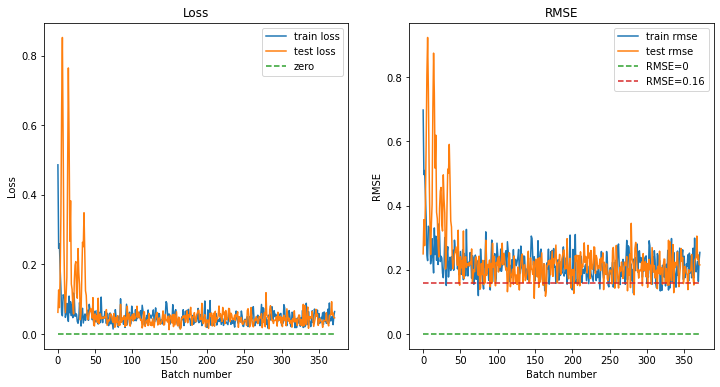

In [12]:
epochs = 1

train_rmse = []
test_rmse = []

train_losses = []
test_losses = []

for epoch in range(epochs):
    for train in train_dataloader:
        
        model.train()
        data_train = train['image'].to(device)#.permute(0, 3, 1, 2)
        target_train = train['label'].to(device)
        
        optimizer.zero_grad()
        out_train = model(data_train)
#         _, preds_train = torch.max(out_train, 1)
        train_loss = criterion(out_train.reshape(-1), target_train.float())

        train_loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
        
        test = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = test['image'].to(device)#.permute(0, 3, 1, 2)
            target_test = test['label'].to(device)
            out_test = model(data_test)
#             _, preds_test = torch.max(out_test, 1)
            test_loss = criterion(out_test.reshape(-1), target_test.float())

        # y_true = train['label'].cpu().numpy()
#         preds_train = preds_train * 10 + 5
        y_pred = out_train.data.cpu()
        train_rmse.append(mean_squared_error(target_train.cpu(), y_pred, squared=False))

        # y_true_test = test['label'].cpu().numpy()
#         preds_test = preds_test * 10 + 5
        y_pred_test = out_test.data.cpu()
        test_rmse.append(mean_squared_error(target_test.cpu(), y_pred_test, squared=False))
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        
        plot_progress(train_losses, train_rmse, test_losses, test_rmse)
        
        exp_lr_scheduler.step()

In [13]:
# model.eval()
# preprocess = get_transform(False, (520, 520))

# y_pred = []
# y_true = []
# for i in tqdm(data_to_test.index):
#     img_name = data_to_test['Id'][i]
#     image = Image.open('../input/petfinder-pawpularity-score/train/' + img_name + '.jpg').convert('RGB')
#     image = preprocess(image)
#     with torch.no_grad():
#         image = image.unsqueeze_(0).to(device)
#         out_test = model(image)
# #         _, output = torch.max(out_test, 1)
# #         output = output * 10 + 5
#         output = out_test.cpu()
#         y_true.append(data_to_test.loc[i, 'Pawpularity'])
#         y_pred.append(output[0])
# mean_squared_error(y_true, y_pred, squared=False)

In [14]:
model.eval()
preprocess = get_transform(False, (520, 520))

for i in tqdm(sample_submission.index):
    img_name = sample_submission['Id'][i]
    image = Image.open('../input/petfinder-pawpularity-score/test/' + img_name + '.jpg').convert('RGB')
    image = preprocess(image)
    with torch.no_grad():
        image = image.unsqueeze_(0).to(device)
        out_test = model(image)
#         _, output = torch.max(out_test, 1)
#         output = output * 10 + 5
        output = out_test.cpu()
        sample_submission.loc[i, 'Pawpularity'] = output[0].numpy()[0] * 100
        

100%|██████████| 8/8 [00:00<00:00, 31.75it/s]


In [15]:
sample_submission.to_csv('sub0.csv', index=False)

In [16]:
sample_submission

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.165553
1,43a2262d7738e3d420d453815151079e,38.923919
2,4e429cead1848a298432a0acad014c9d,38.906789
3,80bc3ccafcc51b66303c2c263aa38486,38.867062
4,8f49844c382931444e68dffbe20228f4,38.902906
5,b03f7041962238a7c9d6537e22f9b017,39.053282
6,c978013571258ed6d4637f6e8cc9d6a3,38.930970
7,e0de453c1bffc20c22b072b34b54e50f,38.861662
